# Unsupervised Learning as Signals for Pairs Trading

<a href="https://www.kaggle.com/addarm/unsupervised-learning-as-signals-for-pairs-trading" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![alt](./images/banner.PNG)

In this article, we will leverage clustering alogrithms to detect pairs in a universe on tradable securities. We will train three unsupervised learning models: KMeans, DBScan, and Agglomerative, to find stocks that have similar characteristics and movements. When one of these deviates from the cluster, that will be our signal to trade.

The models were inspired by the paper Han et al. (2023), which explores the use of unsupervised learning in statistical arbitrage, specifically pairs trading.

```BibTeX
@article{han2023pairs,
  title={Pairs trading via unsupervised learning},
  author={Han, Chulwoo and He, Zhaodong and Toh, Alenson Jun Wei},
  journal={European Journal of Operational Research},
  volume={307},
  number={2},
  pages={929--947},
  year={2023},
  publisher={Elsevier}
}
```


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install scikit-learn
    %pip install tensorflow
    %pip install tqdm
    %pip install matplotlib
    %pip install python-dotenv
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

os.getcwd()

Running Local...


'c:\\Users\\adamd\\workspace\\pairs_trading_unsupervised_learning'

In [2]:
MIN_YEAR= 1980
MAX_YEAR=2021
CHUNKS = 10000

FILEPATH = f"./data/historic_characteristics.csv"
FILEPATH_PARQ = f"./data/historic_characteristics_{MIN_YEAR}_{MAX_YEAR}.parquet"
FILEPATH_MOM_PARQ = f"./data/data_mom_{MIN_YEAR}_{MAX_YEAR}.parquet"
FILEPATH_CLEAN_PARQ = f"./data/data_cleaning_{MIN_YEAR}_{MAX_YEAR}.parquet"
FILEPATH_PRE_PARQ = f"./data/data_preprocessed_{MIN_YEAR}_{MAX_YEAR}.parquet"

AGG_CLUSTERS_FILEPATH = f"./data/agg_clusters_data_{MIN_YEAR}_{MAX_YEAR}.pkl"
AGG_CLUSTERS_MEM_FILEPATH = f"./data/agg_clusters_memdata_{MIN_YEAR}_{MAX_YEAR}.pkl"
KM_CLUSTERS_FILEPATH = f"./data/km_clusters_data_{MIN_YEAR}_{MAX_YEAR}.pkl"
KM_CLUSTERS_MEM_FILEPATH = f"./data/km_clusters_memdata_{MIN_YEAR}_{MAX_YEAR}.pkl"
DBS_CLUSTERS_FILEPATH = f"./data/dbs_clusters_data_{MIN_YEAR}_{MAX_YEAR}.pkl"
DBS_CLUSTERS_MEM_FILEPATH = f"./data/dbs_clusters_memdata_{MIN_YEAR}_{MAX_YEAR}.pkl"

SIGNALS_KM_FILEPATH = f"./data/signals_km_{MIN_YEAR}_{MAX_YEAR}.pkl"
SIGNALS_DB_FILEPATH = f"./data/signals_db_{MIN_YEAR}_{MAX_YEAR}.pkl"
SIGNALS_AGG_FILEPATH = f"./data/signals_agg_{MIN_YEAR}_{MAX_YEAR}.pkl"
PCA_FILEPATH = f"./data/pca_{MIN_YEAR}_{MAX_YEAR}.pkl"

FEATURES = [
    "DATE", "absacc", "acc", "aeavol", "age", "agr", "baspread", "beta", "betasq", "bm",
    "bm_ia", "cash", "cashdebt", "cashpr", "cfp", "cfp_ia", "chatoia", "chcsho", "chempia",
    "chinv", "chmom", "chpmia", "chtx", "cinvest", "convind", "currat", "depr", "divi",
    "divo", "dolvol", "dy", "ear", "egr", "ep", "gma", "herf", "hire", "idiovol", "ill",
    "indmom", "invest", "lev", "lgr", "maxret", "mom1m", "ms", "mve_ia", "mvel1", "nincr",
    "operprof", "pchcapx_ia", "pchcurrat", "pchdepr", "pchgm_pchsale", "pchquick",
    "pchsale_pchrect", "pctacc", "permno", "pricedelay", "ps", "quick", "rd", "retvol",
    "roaq", "roeq", "roic", "rsup", "salecash", "salerec", "securedind", "sgr", "sic2",
    "sin", "sp", "std_dolvol", "std_turn", "tang", "tb", "turn", "zerotrade"
]
WINDOW = 48
MOM_FEATURES = [f"mom{i}m" for i in range(1, WINDOW + 1)]

# Firm Characteristics Data

All papers referenced in this article leverage the CRSP research data on securities. Sepcifically they look at the company characteristics, presented in the table below:

| Acronym  | Firm characteristic                                           | Acronym    | Firm characteristic                                       |
|----------|--------------------------------------------------------------|------------|----------------------------------------------------------|
| absacc   | Absolute accruals                                            | invest     | Capital expenditures and inventory                        |
| acc      | Working capital accruals                                     | IPO        | New equity issue                                          |
| aeavol   | Abnormal earnings announcement volume                        | lev        | Leverage                                                  |
| age      | # years since first Compustat coverage                       | lgr        | Growth in long-term debt                                  |
| agr      | Asset growth                                                  | maxret     | Maximum daily return                                      |
| baspread | Bid-ask spread                                               | ms         | Financial statement score                                 |
| beta     | Beta                                                         | mve        | Size                                                      |
| betasq   | Beta squared                                                 | mve ia     | Industry-adjusted size                                    |
| bm       | Book-to-market                                               | nincr      | Number of earnings increases                              |
| bm ia    | Industry-adjusted book to market                             | operprof   | Operating profitability                                   |
| cash     | Cash holdings                                                | pchcapx ia | Industry adjusted % change in capital expenditures        |
| cashdebt | Cash flow to debt                                            | pchcurrat  | % change in current ratio                                 |
| cashpr   | Cash productivity                                            | pchdepr    | % change in depreciation                                  |
| cfp      | Cash flow to price ratio                                     | pchgm      | % change in gross margin                                  |
| cfp ia   | Industry-adjusted cash flow to price ratio                   | pchsale    | % change in sales                                         |
| chatoia  | Industry-adjusted change in asset turnover                   | pchquick   | % change in quick ratio                                   |
| chcsho   | Change in shares outstanding                                 | pctacc     | Percent accruals                                          |
| chempia  | Industry-adjusted change in employees                        | pricedelay | Price delay                                               |
| chinv    | Change in inventory                                          | ps         | Financial statements score                                |
| chmom    | Change in 6-month momentum                                   | quick      | Quick ratio                                               |
| chpmia   | Industry-adjusted change in profit margin                    | rd         | R&D increase                                              |
| chtx     | Change in tax expense                                        | retvol     | Return volatility                                         |
| cinvest  | Corporate investment                                         | roaq       | Return on assets                                          |
| convind  | Convertible debt indicator                                   | roeq       | Return on equity                                          |
| currat   | Current ratio                                                | roic       | Return on invested capital                                |
| depr     | Depreciation / PP&E                                          | rsup       | Revenue surprise                                          |
| divi     | Dividend initiation                                          | sgr        | Sales growth                                              |
| divo     | Dividend omission                                            | sin        | Sin stocks                                                |
| dolvol   | Dollar trading volume                                        | SP         | Sales to price                                            |
| dy       | Dividend to price                                            | std dolvol | Volatility of liquidity (dollar trading volume)          |
| ear      | Earnings announcement return                                 | std turn   | Volatility of liquidity (share turnover)                  |
| egr      | Growth in common shareholder equity                          | sue        | Unexpected quarterly earnings                             |
| ep       | Earnings to price                                            | tang       | Debt capacity/firm tangibility                            |
| gma      | Gross profitability                                          | tb         | Tax income to book income                                 |
| herf     | Industry sales concentration                                 | turn       | Share turnover                                            |
| hire     | Employee growth rate                                         | zerotrade  | Zero trading days                                         |
| idiovol  | Idiosyncratic return volatility                              |            |                                                           |
| ill      | Illiquidity                                                  |            |                                                           |
| indmom   | Industry momentum                                            |            |                                                           |


Additionally, there are PERMNO and MOM1M columns to ID the company and its momuntum, and a **SIC code** to ID the industry from [NAICS](https://www.naics.com/sic-codes-industry-drilldown/) to compliment the industires momentum **INDMOM**.

On writing this article, we had no visilbity on the individual stocks as we couldn't translate the PERMNO - it requires an active subscription to CRSP. Although we don't see the prices of the equities, we can use the MOM1M characteristic as a proxy for price change. MOM1M is the momentum for one month, or in our case, just the returns in decimal.

## Parquet Dataset Creation

The dataset is large, around 3GB of company characteristics from 1985 to 2021. This dataset has been currated for the papers ["Empirical Asset Pricing via Machine Learning"](https://dachxiu.chicagobooth.edu/download/ML.pdf)(2018) and ["Autoencoder Asset Pricing Models." ](https://www.sciencedirect.com/science/article/abs/pii/S0304407620301998)(2019) by Shihao Gu, Bryan Kelly and Dacheng Xiu. The raw format is available for download from the authors personal websites (or reach out to me for a currated dataset). The dataset has 94 one month Lagged Firm Characteristics (as the CRSP releases these with a month delay, from the notes in their papers).

Using **pyarrow**, we will convert everything to paraquet for speedy processing.

In [3]:
import pyarrow as pa
import pyarrow.parquet as pq
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd

if not os.path.exists(FILEPATH_PARQ):
    chars_df = pd.read_csv(FILEPATH)[FEATURES]
    chars_df['DATE'] = pd.to_datetime(chars_df['DATE'], format='%Y%m%d')
    chars_df = chars_df[(chars_df['DATE'].dt.year >= MIN_YEAR) & (chars_df['DATE'].dt.year <= MAX_YEAR)]
    chars_df = chars_df.sort_values("DATE")
    chars_df.to_parquet(FILEPATH_PARQ, index=False, compression="snappy")
else:
    chars_df = pd.read_parquet(FILEPATH_PARQ)

chars_df.head(5)

,DATE,absacc,acc,aeavol,age,agr,baspread,beta,betasq,bm,...,sgr,sic2,sin,sp,std_dolvol,std_turn,tang,tb,turn,zerotrade
0,1980-01-31,0.113203,0.113203,1.001090,17.0,-0.173800,0.014234,1.060420,1.124491,1.724617,...,0.156975,37.0,0.0,3.063197,0.881844,0.635898,0.545459,0.173391,0.319863,1.115306e-07
1,1980-01-31,0.049921,0.049921,NaN,8.0,-0.266184,0.099243,1.378908,1.901387,2.326257,...,0.099281,59.0,0.0,8.509354,NaN,NaN,0.563272,0.204887,NaN,NaN
2,1980-01-31,0.038596,0.038596,2.862434,8.0,-0.041359,0.012620,1.147547,1.316864,2.244966,...,0.026621,39.0,0.0,4.129895,0.772788,0.600652,0.612665,-0.884532,0.214943,1.310880e-07
3,1980-01-31,0.148813,0.148813,0.208791,8.0,-0.077528,0.027943,0.536016,0.287313,2.053509,...,0.006643,51.0,0.0,7.211359,0.822114,0.520015,0.672020,0.309224,0.094820,7.350000e+00
4,1980-01-31,NaN,NaN,NaN,NaN,NaN,0.149658,NaN,NaN,NaN,...,NaN,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Sanitization and Feature Engineering

To sanitinize our dataset, we drop any company with insufficiant data to fill a window of 48 months and drop characteristics with more than 15% nans. We then impute any missing characteristic with the median of the current time window. 

The data has a one month momentum (MOM1M). MOM is the stock's acceleration measure and is calculated as follows:
$$
\text{MOM}_{\text{1 month}} = \left( \frac{\text{Price at End of Month} - \text{Price at Start of Month}}{\text{Price at Start of Month}} \right) \times 100
$$
Although we don't have a method to convert PERMNO to the actual stock and calculate its price, MOM already provides that change for 1 month.

Using a rolling window for 2 to 64 months, we calculate addtional MOM characteristics:
For $i = 1, mom_i = r_{t-1}, \quad i = 1$ where $r_{t-1}$ denotes the return in the previous month.

For $i > 1$, we calculate the momentum over a window of $i$ months by:
$$
mom_i = \left( \prod_{j=t-i}^{t-2} (r_j + 1) \right) - 1, \quad i \in \{2, \ldots, 48\},
$$
where \(r_j\) denotes the return in month \(j\).

These moving averages help us capture trends. By using 1 to 64 window sizes, it will allow the models to capture both short-term and long-term trends. While clustering is distance and hierarchy based, we do want to add some temporal dynamics allowing the clustering algorithms to consider the timeseries behaviors.

In [4]:
NAN_THRESHOLD = 0.15

def interpolate_with_median(group):
    rolling_median = group.rolling(window=WINDOW, min_periods=1).median()
    group= group.fillna(rolling_median).bfill()
    return group

if not os.path.exists(FILEPATH_PRE_PARQ):
    valid_groups = chars_df.groupby('permno').filter(lambda x: len(x) >= WINDOW and x[MOM_FEATURES[0]].isna().sum() <= 2)
    for i in tqdm(range(2, WINDOW + 1), desc="moms"):
        rolling_func = lambda x: (x + 1).rolling(window=i).apply(np.prod, raw=True) - 1
        valid_groups[f'mom{i}m'] = valid_groups.groupby('permno')[MOM_FEATURES[0]].transform(rolling_func)

    numerical_columns = valid_groups.select_dtypes(include=['float64', 'int64']).columns

    tqdm.pandas(desc="interpolate_with_median")
    valid_groups[numerical_columns] = valid_groups.groupby('permno')[numerical_columns].progress_transform(lambda x: interpolate_with_median(x))

    nan_percentages = valid_groups[FEATURES].isna().mean()
    valid_groups = valid_groups.drop(columns=nan_percentages[nan_percentages >= NAN_THRESHOLD].index)
    valid_groups = valid_groups.ffill().bfill()

    valid_groups.to_parquet(FILEPATH_PRE_PARQ, index=False, compression="snappy")
    chars_df = valid_groups
else:
    chars_df = pd.read_parquet(FILEPATH_PRE_PARQ)

chars_df.tail(5)

,DATE,absacc,acc,aeavol,age,agr,baspread,beta,betasq,bm,...,mom39m,mom40m,mom41m,mom42m,mom43m,mom44m,mom45m,mom46m,mom47m,mom48m
3094143,2021-12-31,0.067623,-0.067623,-0.033631,28.0,-0.364472,0.028294,1.441246,2.077190,0.048185,...,-0.160019,-0.209986,-0.207510,-0.202510,-0.141996,-0.112534,-0.138494,-0.239209,-0.193775,-0.215214
3094144,2021-12-31,0.024879,-0.024879,0.151201,37.0,0.012825,0.022583,0.958245,0.918234,0.344213,...,0.317601,0.393385,0.390042,0.374003,0.472146,0.450648,0.440951,0.408930,0.429655,0.385778
3094145,2021-12-31,0.024879,-0.024879,0.151201,37.0,0.012825,0.016800,1.255085,1.575239,0.344213,...,0.035717,0.010717,0.021282,0.021282,0.046153,0.132309,0.124301,0.012310,0.044965,0.091738
3094146,2021-12-31,0.024879,-0.024879,0.151201,37.0,0.012825,0.008384,0.866276,0.750434,0.344213,...,0.540994,0.582306,0.625281,0.623059,0.640682,0.665625,0.621044,0.595880,0.640901,0.684288
3094147,2021-12-31,0.120800,-0.120800,-0.106147,11.0,-0.519951,0.056249,1.504264,2.262812,0.033035,...,16.967672,17.179807,14.804426,18.036026,17.442083,19.366467,14.799359,14.297700,16.408472,16.549386


## Dim Reduction with PCA

Standardization and PCA at 99% variance is performed to center the data's means for the clustering algorithims, and slightly reduce its dimensionality - in the paper, PCA is used primarly for scaling and capturing magnitudes and they utilizew components that describe 100% variance.

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

MAX_VARIANCE = 0.99

chars_pca_df = chars_df.copy()
if os.path.exists(PCA_FILEPATH):
    pca_result_df = pd.read_pickle(PCA_FILEPATH)
else:
    scaler = StandardScaler()
    pca = PCA(MAX_VARIANCE)
    features_df = chars_pca_df.drop(['DATE', 'permno'], axis=1).bfill()
    pipeline = Pipeline([('scaler', scaler), ('pca', pca)])
    pca_df = pipeline.fit_transform(features_df)

    pca_result_df = pd.DataFrame(data=pca_df, index=chars_pca_df.index)

    pca_result_df['permno'] = chars_pca_df['permno']
    pca_result_df[MOM_FEATURES] = chars_pca_df[MOM_FEATURES]
    pca_result_df['DATE'] = chars_pca_df['DATE']

    pca_result_df.to_pickle(PCA_FILEPATH)


assert not pca_result_df.isna().any().any()

pca_result_df

,0,1,2,3,4,5,6,7,8,9,...,mom40m,mom41m,mom42m,mom43m,mom44m,mom45m,mom46m,mom47m,mom48m,DATE
772496,0.265899,0.674451,-1.652120,0.395952,-0.565655,-1.103431,-0.094360,-1.419500,-0.206718,0.480775,...,0.171989,0.250122,0.240010,0.281808,0.263231,0.192639,0.639879,0.598882,0.684156,1980-01-31
775697,11.967859,-3.284518,1.273922,-0.442356,0.714568,-1.284806,1.237741,0.285090,0.002585,0.428468,...,4.712689,4.822549,4.822549,4.777726,4.777726,3.454583,3.475753,2.988295,2.434365,1980-01-31
775694,6.033713,0.180376,-0.333589,-0.536354,2.683301,-0.908306,-0.153683,-1.728202,-2.531858,0.244755,...,2.123810,2.276190,3.038095,3.247619,3.038095,3.152381,3.285714,4.028571,3.876190,1980-01-31
775693,-0.607416,0.427278,1.818217,-0.125194,3.134476,-0.368272,1.370615,-0.577570,-1.643695,0.520253,...,0.606844,0.483240,1.031189,1.178377,0.942876,0.619064,0.324688,0.560189,0.354126,1980-01-31
775692,2.632038,0.331278,-1.523178,-0.362489,1.849902,-1.739659,-0.602280,-1.495353,-0.871855,-0.145022,...,1.599627,1.517494,1.440624,1.440624,1.356836,1.435397,1.428326,1.508602,1.388189,1980-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4112551,-1.919868,-0.433977,-2.288112,1.879089,-1.207388,0.885580,1.322246,-0.178839,-1.260473,-0.505992,...,-0.209986,-0.207510,-0.202510,-0.141996,-0.112534,-0.138494,-0.239209,-0.193775,-0.215214,2021-12-31
4112694,-0.697372,-0.779734,-2.455765,0.805985,-0.778958,1.436156,0.571926,-0.348115,-0.680187,1.151944,...,0.393385,0.390042,0.374003,0.472146,0.450648,0.440951,0.408930,0.429655,0.385778,2021-12-31
4112688,0.689789,1.320202,-2.589043,1.458455,-1.001330,1.054757,0.394751,-0.317406,-0.663371,1.128673,...,0.010717,0.021282,0.021282,0.046153,0.132309,0.124301,0.012310,0.044965,0.091738,2021-12-31
4112682,1.413643,-0.257837,-2.872211,1.033289,-0.662100,1.233736,-0.014206,-0.258818,0.015957,0.985149,...,0.582306,0.625281,0.623059,0.640682,0.665625,0.621044,0.595880,0.640901,0.684288,2021-12-31


# Clustering

In [6]:
from sklearn.neighbors import NearestNeighbors

def distance_to_nearest_neighbors(df, k = 2, alpha = 0.3):
    """
    Calculates the distance to the nearest neighbors of each point in a DataFrame and determines a distance threshold based on a percentile.

    Computes the L2 nearest neighbors for each point in the dataset.
    It then calculates the average distance to the nearest neighbors, excluding the closest one (itself for k=2), across all points a threshold is used as cut-off distance for clustering or outlier detection.
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the data points.
    - k (int, optional): The number of nearest neighbors to consider. The default is 2 (itself and another).
    - alpha (int, optional): The percentile from 1.0 to 0.0 to use when determining the distance threshold.

    Returns:
    - A tuple containing:
        - NumPy array of distances.
        - Epsilon threshold.
    """

    neigh = NearestNeighbors(n_neighbors=k, n_jobs=-1, metric='l2')
    nbrs = neigh.fit(df)
    distances, _ = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1:].mean(axis=1)
    epsilon = np.percentile(distances, alpha*100)

    return distances, epsilon

pca_result_df.columns = pca_result_df.columns.astype(str)
pca_components_cols = pca_result_df.drop('DATE', axis=1).columns
pca_components_cols

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       'mom39m', 'mom40m', 'mom41m', 'mom42m', 'mom43m', 'mom44m', 'mom45m',
       'mom46m', 'mom47m', 'mom48m'],
      dtype='object', length=139)

## KMeans

KMeans aims to minimize the sum of square distances between points (eucladien distance) in a two-step procedure that assigns the points (*xi*) to a cluster (*uj*), and then recalculating the clusters' centroids (*uj*) with the means of all the assigned data - iterated until convergence (the max clusters requested). This is represented as:

$$
J = \sum_{i=1}^{n} \sum_{j=1}^{k} \left\| x_i^{(j)} - \mu_j \right\|^2
$$
Where:
- *n* is the total data points.
- *k* is the total clusters
- *xi^j* is the ith point assigned to the jth cluster
- *uj* is the centroid of the jth cluster.

The problem of kmeans is that it cannot identify outliers, therefore the centroids get skewed. In this case, we will need to find the distances to the centroids, and drop anything larger than the *alpha* threshold of the 2 nearest neighbours. 

![kmeans](./images/Flowchart-of-k-means-clustering-algorithm.png)

The paper stops here with KMeans, though if we had to improve on this - we would detect the optimal number of clusters using the elbow method or the silhouetter score, then on the removal of outliers - refit the KMeans model to have the correctly sized clusters without outliers.

In [7]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

def find_optimal_clusters(data, max_clusters=20):
    """
    Identifies the optimal number of clusters using the Silhouette Coefficient.
    We use MiniBatchKMeans to reduce the computation time at the cost of a slight decrease in accuracy.
    See: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html
    Parameters:
    - data: DataFrame containing the data points.
    - max_clusters: Maximum number of clusters to consider.
    Returns:
    - Optimal number of clusters based on the Elbow Method.
    """
    best_score = -1
    best_k = 2
    for n_clusters in range(2, max_clusters + 1):
        km = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', n_init=3, max_iter=100, random_state=1, batch_size=100)
        km.fit(data)
        score = silhouette_score(data, km.labels_)
        if score > best_score:
            best_score = score
            best_k = n_clusters
    return best_k

def distance_to_centroid(km_model, df, alpha=30):
    """
    Calculate the distance from each data point in the provided DataFrame to the centroid of its assigned cluster.
    Parameters:
    - km_model: Fitted KMeans model containing cluster centroids.
    - df: DataFrame containing the data points.
    - a: Optional, alpha max dist percentile to get epsilon threshold.

    Returns:
    - A tuple containing:
        - NumPy array of distances from each data point to its centroid.
        - Epsilon threshold, calculated as the alpha percentile of the L2 distances.
    """
    labels = km_model.labels_
    dist_centroid = km_model.transform(df)
    dist_centroid_member = np.array([dist_centroid[i, labels[i]] for i in range(len(labels))])
    epsilon = np.percentile(dist_centroid_member, alpha)

    return dist_centroid_member, epsilon

def train_km_clusters(pca_result_df, optimal_clusters = None):
    models_dfs = []
    cluster_membership = []
    for month, data in tqdm(pca_result_df.groupby("DATE"), desc="train_km_clusters"):
        pca_data = data[pca_components_cols]
        if len(pca_data) < 2:
            print(f"Skipping {month} due to insufficient data.")
            continue
        if not optimal_clusters:
            optimal_clusters = find_optimal_clusters(pca_data, max_clusters=int(round(np.log(len(pca_data)))))
        km_model = KMeans(n_clusters=optimal_clusters,
                          init='k-means++',
                          n_init=10,
                          max_iter=1000,
                          random_state=1)
        km_model.fit(pca_data)

        # We need to refit and remove the outlier securities.
        dist, eps = distance_to_centroid(km_model, pca_data)
        clean_data = pca_data[~(dist > eps)]
        cluster_df = pd.DataFrame(data['permno'].copy(), index=data.index)
        cluster_df = pd.DataFrame(pca_data['permno'].copy(), index=pca_data.index)
        cluster_df['km_cluster'] = km_model.labels_ if km_model is not None else []
        cluster_df.loc[(dist > eps), "km_cluster"] = -1 # Outliers To be similar to DBScan - we set them to -1
        cluster_df[MOM_FEATURES[0]] = data[MOM_FEATURES[0]]
        cluster_df['DATE'] = month
        cluster_membership.append(cluster_df)

        models_dfs.append({'DATE': month, 'n_clusters': km_model.n_clusters})

    models_df = pd.DataFrame(models_dfs)
    cluster_membership_df = pd.concat(cluster_membership, ignore_index=False)

    return models_df, cluster_membership_df

if os.path.exists(KM_CLUSTERS_FILEPATH) and os.path.exists(KM_CLUSTERS_MEM_FILEPATH) :
    km_models_df = pd.read_pickle(KM_CLUSTERS_FILEPATH)
    km_cluster_membership_df = pd.read_pickle(KM_CLUSTERS_MEM_FILEPATH)
else:
    # For k-means clustering, the number of clusters K = 5; 10; 50; 100; 500; 1000, and 1500 are tested
    # and K = 500 is chosen for the main results as it gives the highest Sharpe ratio.
    km_models_df, km_cluster_membership_df = train_km_clusters(pca_result_df, optimal_clusters=500)
    km_models_df.to_pickle(KM_CLUSTERS_FILEPATH)
    km_cluster_membership_df.to_pickle(KM_CLUSTERS_MEM_FILEPATH)

pca_result_df['km_cluster'] = km_cluster_membership_df['km_cluster']
pca_result_df[['DATE', 'km_cluster']].tail(5)

,DATE,km_cluster
4112551,2021-12-31,-1
4112694,2021-12-31,211
4112688,2021-12-31,211
4112682,2021-12-31,211
4117299,2021-12-31,-1


Visualize the clusters composition:

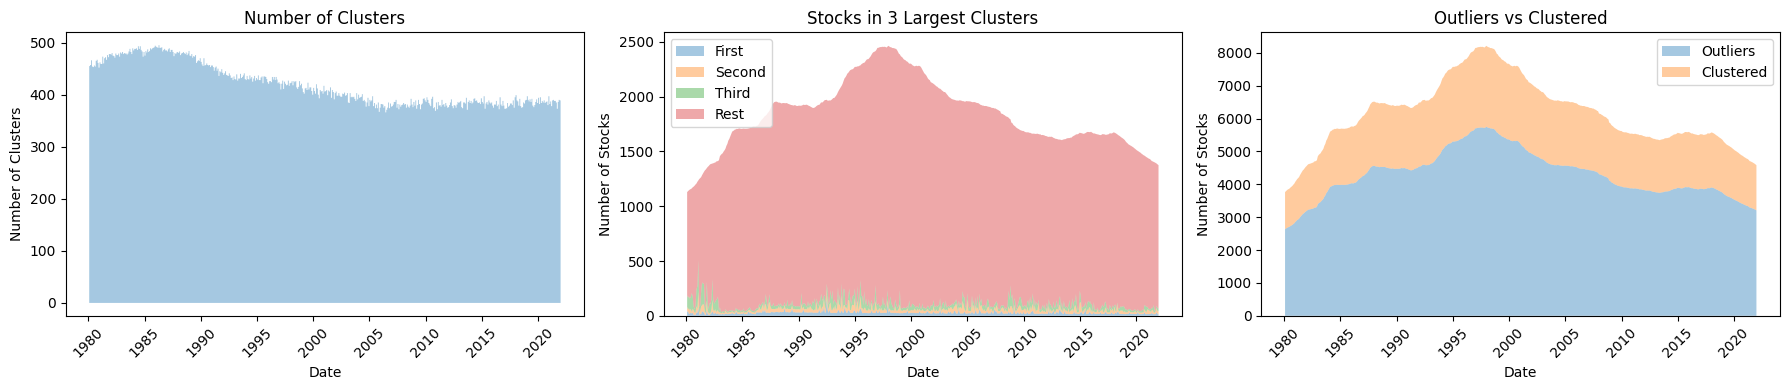

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_cluster_distributions(cluster_membership_df, cluster_col):
    """
    Plots the distribution of clusters over time, including a comparison of outliers versus clustered stocks.
    Parameters:
    - cluster_membership_df: DataFrame containing clustering information.
    - cluster_col: String, the name of the column in DataFrame that contains cluster identifiers.
    """
    clusters = cluster_membership_df[cluster_membership_df[cluster_col] > -1].groupby('DATE')[cluster_col].nunique().reset_index()
    clusters['DATE'] = pd.to_datetime(clusters['DATE'])
    cluster_counts = cluster_membership_df.groupby(['DATE', cluster_col])["permno"].count().reset_index()
    cluster_counts['Rank'] = cluster_counts[cluster_counts[cluster_col] > -1].groupby('DATE')["permno"].rank("dense", ascending=False)
    cluster_counts['Cluster_Group'] = cluster_counts.apply(
        lambda row: 'First' if row['Rank'] == 1 else
                    'Second' if row['Rank'] == 2 else
                    'Third' if row['Rank'] == 3 else
                    'Rest', axis=1)
    cluster_counts['Cluster_Group'] = cluster_counts.apply(
        lambda row: 'Outliers' if row[cluster_col] == -1 else
                    row['Cluster_Group'], axis=1)
    cluster_summary = cluster_counts.groupby(['DATE', 'Cluster_Group'])["permno"].sum().unstack(fill_value=0).reset_index()
    cluster_summary['DATE'] = pd.to_datetime(cluster_summary['DATE'])

    fig, axs = plt.subplots(1, 3 if 'Outliers' in cluster_summary.columns else 2, figsize=(18, 4))

    axs[0].fill_between(clusters['DATE'], clusters[cluster_col], step="pre", alpha=0.4)
    axs[0].set_title('Number of Clusters')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Number of Clusters')
    axs[0].tick_params(axis='x', rotation=45)
    axs[1].stackplot(cluster_summary['DATE'],
                     cluster_summary.get('First', pd.Series()),
                     cluster_summary.get('Second', pd.Series()),
                     cluster_summary.get('Third', pd.Series()),
                     cluster_summary.get('Rest', pd.Series()),
                     labels=['First', 'Second', 'Third', 'Rest'], alpha=0.4)
    axs[1].set_title('Stocks in 3 Largest Clusters')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Number of Stocks')
    axs[1].legend(loc='upper left')
    axs[1].tick_params(axis='x', rotation=45)

    if 'Outliers' in cluster_summary.columns:
        clustered_stocks = cluster_summary[['First', 'Second', 'Third', 'Rest']].sum(axis=1)
        outliers = cluster_summary['Outliers']
        axs[2].stackplot(cluster_summary['DATE'], outliers, clustered_stocks, labels=['Outliers', 'Clustered'], alpha=0.4)
        axs[2].set_title('Outliers vs Clustered')
        axs[2].set_xlabel('Date')
        axs[2].set_ylabel('Number of Stocks')
        axs[2].tick_params(axis='x', rotation=45)
        axs[2].legend()

    return fig, axs

plot_cluster_distributions(km_cluster_membership_df, 'km_cluster')
plt.tight_layout()
plt.show()

## DBSCAN

DBSCAN is a Density Based Spatial Clustering or Applications with Noise, that's a mouthful of a model that identifies areas of high interest in high dimensional data, which we have. It is able to handle clusters of arbitrary shapes, and can deal with outliers.

The algo groups together points that are closely packed together within *ε Epsilon* distance, and assigns a cluster if the number of points are greater than *MinPts*. 
Clusters are areas of high density (called core points) separated by areas of low density (called border points). Points that do not belong to any cluster (further than *ε*) are noise.

The algo expands the radius of a cluster, adding as many neighbours as it can, or creates new clusters m core points and keeps iterating until it has visited every point. The flowchart below gives a good visual representation of this:

![DBScan"](./images/Flowchart-of-the-DBSCAN-algorithm.png)

In the code, we calculate the epsilon distance by finding the distances between two neighbours, order these in percentiles and finding the Alpha percentile - The paper identified the 10% alpha as the optimal one.

In [9]:
from sklearn.cluster import DBSCAN

def train_db_clusters(pca_result_df, alpha=0.1):
    models_dfs = []

    cluster_membership = []
    for month, data in tqdm(pca_result_df.groupby("DATE"), desc="train_db_clusters"):
        pca_data = data[pca_components_cols]
        if len(pca_data) < 2:
            print(f"Skipping {month} due to insufficient data.")
            continue

        #MinPts is set to be the natural logarithm of the total number of data points N
        min_samples = int(round(np.log(len(data))))
        _, eps = distance_to_nearest_neighbors(pca_data, k=min_samples + 1, alpha = alpha)
        db_model = DBSCAN(eps=eps, metric='l2', min_samples=min_samples)
        db_model.fit(pca_data)

        cluster_df = pd.DataFrame(data['permno'].copy(), index=data.index)
        cluster_df['db_cluster'] = db_model.labels_
        cluster_df['DATE'] = month
        cluster_df[MOM_FEATURES[0]] = data[MOM_FEATURES[0]]

        cluster_membership.append(cluster_df)
        # -1 are the noise points, which we have to remove.
        num_clusters = len(set(db_model.labels_)) - (1 if -1 in db_model.labels_ else 0)

        models_dfs.append({'DATE': month, 'n_clusters': num_clusters})

    models_df = pd.DataFrame(models_dfs)
    cluster_membership_df = pd.concat(cluster_membership, ignore_index=False)

    return models_df, cluster_membership_df

if os.path.exists(DBS_CLUSTERS_FILEPATH) and os.path.exists(DBS_CLUSTERS_MEM_FILEPATH) :
    db_models_df = pd.read_pickle(DBS_CLUSTERS_FILEPATH)
    db_cluster_membership_df = pd.read_pickle(DBS_CLUSTERS_MEM_FILEPATH)
else:
    # For DBSCAN alpha = 0:1; : : : ; 0:9 are tested, and alpha = 0:1 is chosen for DBSCAN
    db_models_df, db_cluster_membership_df = train_db_clusters(pca_result_df, alpha=0.1)
    db_models_df.to_pickle(DBS_CLUSTERS_FILEPATH)
    db_cluster_membership_df.to_pickle(DBS_CLUSTERS_MEM_FILEPATH)

pca_result_df['db_cluster'] = db_cluster_membership_df['db_cluster']
pca_result_df[['DATE', 'db_cluster']].tail(5)

,DATE,db_cluster
4112551,2021-12-31,-1
4112694,2021-12-31,-1
4112688,2021-12-31,-1
4112682,2021-12-31,-1
4117299,2021-12-31,-1


And we visualize the clustering:

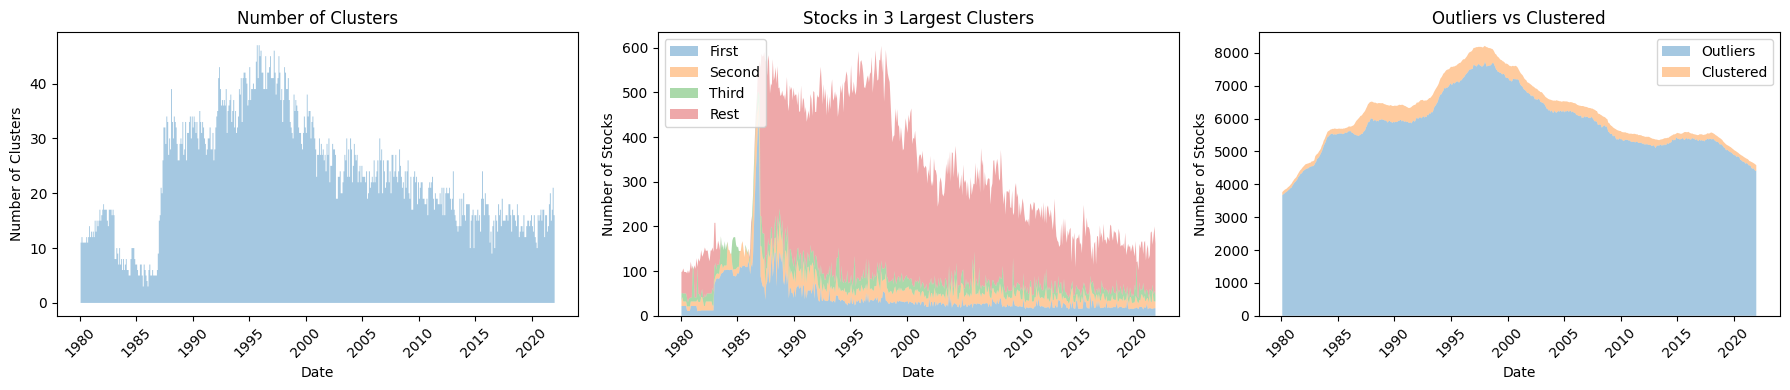

In [10]:
plot_cluster_distributions(db_cluster_membership_df, 'db_cluster')
plt.tight_layout()
plt.show()

## Agglomerative

Agglomerative is a hierarchical cluster algo that works iteratively bottom-up, by merging closest pairs of clusters until it converges to one cluster, or meeting a criterion.

In our case, the criterion is the *ε Epsilon* distance, which means the algo will iterate until the distance between neighboring clusters is more than *ε*.

![Agg"](./images/Flow-chart-of-agglomerative-hierarchical-clustering.png)

Like DBScan, epsilon is solved through the alpha parameter - in this case, the paper states that 30% is the optimal alpha.

In [11]:
from sklearn.cluster import AgglomerativeClustering

def train_agg_clusters(pca_result_df, alpha=0.3):
    models_dfs = []

    cluster_membership = []
    for month, data in tqdm(pca_result_df.groupby("DATE"), desc="train_agg_clusters"):
        pca_data = data[pca_components_cols]
        if len(pca_data) < 2:
            print(f"Skipping {month} due to insufficient data.")
            continue

        _, eps = distance_to_nearest_neighbors(pca_data, alpha = alpha)
        agg_model = AgglomerativeClustering(n_clusters=None, distance_threshold=eps, linkage='average')
        agg_model.fit(pca_data)

        cluster_df = pd.DataFrame(data['permno'].copy(), index=data.index)
        cluster_df['agg_cluster'] = agg_model.labels_
        cluster_df['DATE'] = month
        cluster_df[MOM_FEATURES[0]] = data[MOM_FEATURES[0]]

        cluster_membership.append(cluster_df)

        models_dfs.append({'DATE': month, 'n_clusters': agg_model.n_clusters_})

    models_df = pd.DataFrame(models_dfs)
    cluster_membership_df = pd.concat(cluster_membership, ignore_index=False)

    return models_df, cluster_membership_df

if os.path.exists(AGG_CLUSTERS_FILEPATH) and os.path.exists(AGG_CLUSTERS_MEM_FILEPATH) :
    agg_models_df = pd.read_pickle(AGG_CLUSTERS_FILEPATH)
    agg_cluster_membership_df = pd.read_pickle(AGG_CLUSTERS_MEM_FILEPATH)
else:
    # alpha = 0:3 for agglomerative clustering
    agg_models_df, agg_cluster_membership_df = train_agg_clusters(pca_result_df, alpha=0.3)
    agg_models_df.to_pickle(AGG_CLUSTERS_FILEPATH)
    agg_cluster_membership_df.to_pickle(AGG_CLUSTERS_MEM_FILEPATH)

pca_result_df['agg_cluster'] = agg_cluster_membership_df['agg_cluster']
pca_result_df[['DATE', 'agg_cluster']].tail(5)

,DATE,agg_cluster
4112551,2021-12-31,551
4112694,2021-12-31,749
4112688,2021-12-31,287
4112682,2021-12-31,287
4117299,2021-12-31,1154


We visualize the clusters, though we can see aberations in the clustering - with 1985 being the pivot point in the clusters' members.

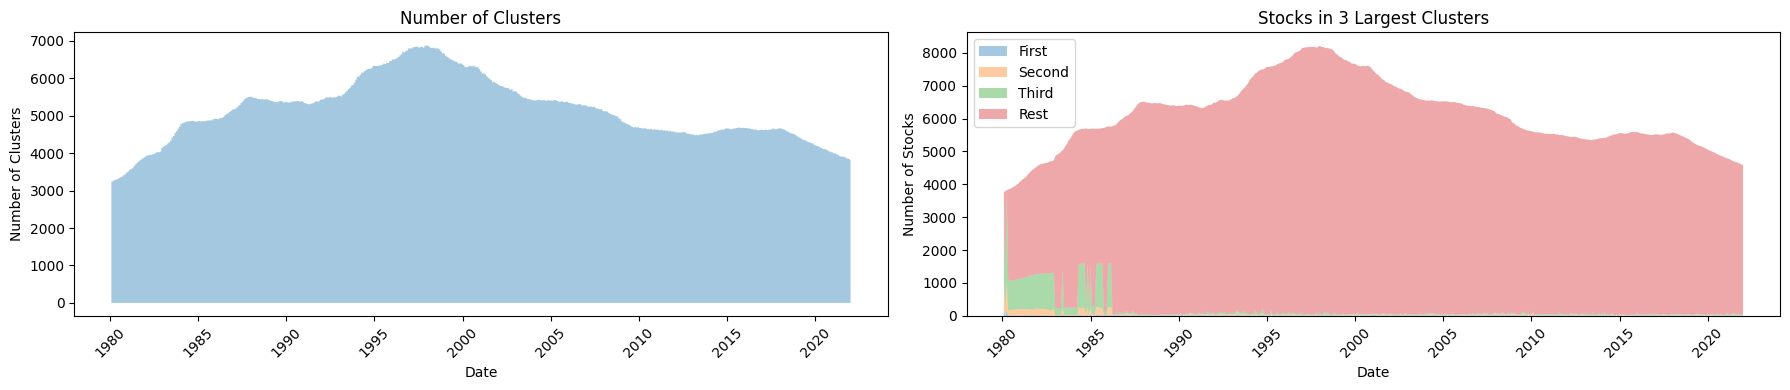

In [12]:
plot_cluster_distributions(agg_cluster_membership_df, 'agg_cluster')
plt.tight_layout()
plt.show()

# Trade Simulation

Our simulated trades will take the following steps:
1. Get all securities in a cluster.
2. Split into deciles based on ther returns (MOM1).
3. Get returns delta of the top decile (over valued) and bottom decile (under valued)
4. Calculate the cross-sectional standard deviation of these deltas.
5. If delta > cluster's 1 std * factor - there is a statarb opportunity. The factor is a parameter, which in our case it's 1.5.
6. Select securities for the Long-Short portoflio to be traded the next month.
7. Close Long-Shorts from previous month (we assume these have reversed back to the cluster's mean).

All portfolios will be Equally Weighted, with their returns unaltered (*w_i* will be 1). We will also assume *15BPs* trade fees, which will be deducted from the returns:

$$
R_p = \sum_{i=1}^{n} (w_i \cdot (r_i - 0.0015))
$$

In [13]:
from pandas import Timestamp
from datetime import datetime, timedelta

RETS = 'rets'
OVER_RETS = 'over_rets'
UNDER_RETS = 'under_rets'
RETS_1 = MOM_FEATURES[0]

def statarb_signals(group, std_dev_factor=1.5):
    """
    Finds signals for a given cluster of stocks by identifying overvalued ("overs") and undervalued ("unders") stocks
    in the top and bottom deciles, where the momentum difference exceeds a specified standard deviation factor, using pd.qcut.

    Parameters:
    - group (pd.DataFrame): Stock data for a specific group or cluster.
    - std_dev_factor (float, optional): The factor by which the standard deviation is multiplied to determine signal. Defaults to 1.

    Returns:
    - list of dicts:
        - 'DATE': The trade date for the identified signals.
        - 'Cluster': The identifier for the cluster from which the signals were generated.
        - 'overs': A set of stock identifiers ('permno') considered overvalued based on the strategy.
        - 'unders': A set of stock identifiers ('permno') considered undervalued based on the strategy.
    """
    overs = unders = []
    overs_rets = unders_rets = 0
    if len(group[MOM_FEATURES[0]]) > 1:
        group_sorted = group.sort_values(by=RETS_1, ascending=False).reset_index(drop=True)
        mid_idx = len(group_sorted) // 2
        top_half = group_sorted.iloc[:mid_idx]
        bottom_half = group_sorted.iloc[-mid_idx:]

        assert len(top_half) == len(bottom_half), f"len mismatch: {len(top_half) } != {len(bottom_half)}"

        if not bottom_half.empty and not top_half.empty:
            mom1_diffs = top_half[RETS_1].values - bottom_half[RETS_1].values
            mom1_std_dev = mom1_diffs.std()
            rets_diffs =  top_half[RETS_1].values - bottom_half[RETS_1].values
            valid_pairs_mask = rets_diffs > (mom1_std_dev * std_dev_factor)
            overs = top_half[valid_pairs_mask]['permno']
            unders = bottom_half[valid_pairs_mask]['permno']

            overs_rets = top_half[valid_pairs_mask][RETS].mul(-1).mean()
            unders_rets = bottom_half[valid_pairs_mask][RETS].mean()

    return [{
        'DATE': group['DATE_TRADE'].iloc[0],
        'Cluster': group['cluster'].iloc[0],
        'overs': set(overs),
        'unders': set(unders),
        OVER_RETS: overs_rets,
        UNDER_RETS: unders_rets,
        RETS: (overs_rets + unders_rets),
    }]


def process_trade_opportunities(df, cluster_label, filepath):
    df['cluster'] = df[cluster_label]

    tqdm.pandas(desc=f"StatArb opportunities with {cluster_label}")
    trade_opportunities = df.groupby(['cluster', 'DATE']).progress_apply(statarb_signals)
    trade_opportunities = [item for sublist in trade_opportunities for item in sublist]
    if len(trade_opportunities) == 0:
        return pd.DataFrame()

    trade_opportunities_df = pd.DataFrame(trade_opportunities)
    trade_opportunities_df.to_pickle(filepath)
    return trade_opportunities_df

# NB: The model will trade the next month on the selected clusters. Paper rebalances portfolios monthly.
pca_result_df['DATE_TRADE'] = pca_result_df.groupby(['permno'])['DATE'].shift(-1).ffill()
pca_result_df[RETS] = pca_result_df.groupby(['permno'])[RETS_1].shift(-1).ffill()
trade_opportunities_km_df = trade_opportunities_db_df = trade_opportunities_agg_df = None
if not os.path.exists(SIGNALS_KM_FILEPATH):
    trade_opportunities_km_df = process_trade_opportunities(pca_result_df, 'km_cluster', SIGNALS_KM_FILEPATH)
else:
    trade_opportunities_km_df = pd.read_pickle(SIGNALS_KM_FILEPATH)

if not os.path.exists(SIGNALS_DB_FILEPATH):
    trade_opportunities_db_df = process_trade_opportunities(pca_result_df, 'db_cluster', SIGNALS_DB_FILEPATH)
else:
    trade_opportunities_db_df = pd.read_pickle(SIGNALS_DB_FILEPATH)
if not os.path.exists(SIGNALS_AGG_FILEPATH):
    trade_opportunities_agg_df = process_trade_opportunities(pca_result_df, 'agg_cluster', SIGNALS_AGG_FILEPATH)
else:
    trade_opportunities_agg_df = pd.read_pickle(SIGNALS_AGG_FILEPATH)
trade_opportunities_km_df.tail(5)

,DATE,Cluster,overs,unders,over_rets,under_rets,rets
211712,2021-09-30,499,{},{},0.000000,0.000000,0.0
211713,2021-10-29,499,{},{},0.000000,0.000000,0.0
211714,2021-11-30,499,{},{},0.000000,0.000000,0.0
211715,2021-12-31,499,{},{},0.000000,0.000000,0.0
211716,2021-12-31,499,"{89960, 89946, 89942}","{89952, 89949, 89965}",-0.002305,0.002305,0.0


Samples fromt the clusters trade positions can be seen below:

In [14]:
trade_opportunities_db_df.tail(5)

,DATE,Cluster,overs,unders,over_rets,under_rets,rets
12131,1995-12-29,45,"{75810, 75814, 75817, 75803, 75805}","{75808, 75811, 75801, 75806, 75807}",-0.025395,0.043912,0.018517
12132,1996-02-29,45,"{76081, 76082}","{76080, 76083}",-0.036118,-0.045165,-0.081283
12133,1997-04-30,45,"{75449, 75461}","{75465, 75447}",0.037567,-0.082252,-0.044685
12134,1995-10-31,46,"{75626, 75621, 75629}","{75625, 75627, 75623}",-0.008059,0.078049,0.069991
12135,1995-12-29,46,"{75840, 75841, 75842, 75845, 75836}","{75843, 75834, 75835, 75837, 75838}",-0.026670,0.013741,-0.012929


In [15]:
trade_opportunities_agg_df.tail(5)

,DATE,Cluster,overs,unders,over_rets,under_rets,rets
2590418,1998-01-30,6875,{},{},0.0,0.0,0.0
2590419,1998-01-30,6876,{},{},0.0,0.0,0.0
2590420,1998-01-30,6877,{},{},0.0,0.0,0.0
2590421,1998-01-30,6878,{},{},0.0,0.0,0.0
2590422,1998-01-30,6879,{},{},0.0,0.0,0.0


## KMeans

In [16]:
def get_pnl(trade_opportunities_df, fees=0.0015):
    trade_opportunities_df['DATE'] = pd.to_datetime(trade_opportunities_df['DATE'])
    asset_df = pca_result_df.reset_index()[['DATE', 'permno', MOM_FEATURES[0]]].copy()

    overs_df = trade_opportunities_df[["DATE", 'overs', OVER_RETS]].rename(columns={OVER_RETS: f'raw_{OVER_RETS}'})
    unders_df = trade_opportunities_df[["DATE", 'unders', UNDER_RETS]].rename(columns={UNDER_RETS: f'raw_{UNDER_RETS}'})
    overs_df[OVER_RETS] = overs_df[f'raw_{OVER_RETS}'].sub(fees)
    unders_df[UNDER_RETS] = unders_df[f'raw_{UNDER_RETS}'].sub(fees)

    overs_stock_df = pd.merge(overs_df.explode('overs').rename(columns={'overs': 'permno'}), asset_df, left_on=['DATE', 'permno'], right_on=['DATE', 'permno'])
    unders_stock_df = pd.merge(unders_df.explode('unders').rename(columns={'unders': 'permno'}), asset_df, left_on=['DATE', 'permno'], right_on=['DATE', 'permno'])

    unders_df = unders_df.set_index("DATE", drop=False).fillna(0)
    re_unders_df = unders_df.resample('QE', on='DATE')[UNDER_RETS].mean()

    overs_df = overs_df.set_index("DATE", drop=False).fillna(0)
    re_overs_df = overs_df.resample('QE', on='DATE')[OVER_RETS].mean()

    return overs_stock_df, unders_stock_df, overs_df, unders_df, re_unders_df, re_overs_df

overs_stock_df, unders_stock_df, overs_df, unders_df, re_unders_df, re_overs_df = get_pnl(trade_opportunities_km_df)

print(overs_stock_df.groupby('DATE')[OVER_RETS].mean().tail(5))
print(unders_stock_df.groupby('DATE')[UNDER_RETS].mean().tail(5))

DATE
2021-08-31    0.048644
2021-09-30   -0.018659
2021-10-29    0.027098
2021-11-30   -0.030930
2021-12-31    0.018230
Name: over_rets, dtype: float64
DATE
2021-08-31   -0.029962
2021-09-30    0.019528
2021-10-29   -0.027545
2021-11-30    0.025478
2021-12-31   -0.030848
Name: under_rets, dtype: float64


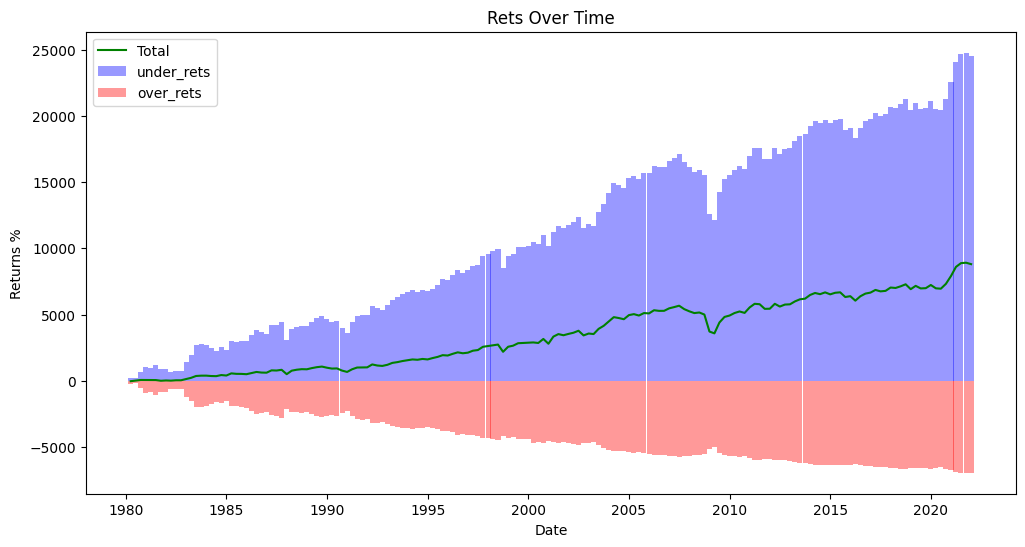

In [17]:
def plot_cummulative_rets(re_unders_df, re_overs_df):
    fig = plt.figure(figsize=(12, 6))

    re_unders_cum_df = re_unders_df.add(1).cumprod().sub(1).mul(100.)
    re_overs_cum_df = re_overs_df.add(1).cumprod().sub(1).mul(100.)

    plt.bar(re_unders_cum_df.index, re_unders_cum_df.mul(100.).values, label=UNDER_RETS, color='b', alpha=0.4, width=365//4)
    plt.bar(re_overs_cum_df.index, re_overs_cum_df.mul(100.).values, label=OVER_RETS, color='r', alpha=0.4, width=365//4)
    plt.plot(re_overs_cum_df.index, ((re_unders_cum_df + re_overs_cum_df) / 2.0 )*100., label="Total", color='g')
    plt.xlabel('Date')
    plt.ylabel('Returns %')
    plt.legend()
    plt.title('Rets Over Time')

    return fig

plot_cummulative_rets(re_unders_df, re_overs_df)
plt.show()

In [18]:
def get_log_rets(re_overs_df, re_unders_df):
    o = re_overs_df.add(1)
    o = np.log(o / o.shift(1).fillna(0))
    u = re_unders_df.add(1)
    u = np.log(u / u.shift(1).fillna(0))

    log_rets = pd.concat([ o, u, o + u], axis=1)
    log_rets.columns = ['Overs', 'Unders', 'Totals']

    overs_count = overs_stock_df.groupby("DATE").size().resample('QE').sum()
    unders_count = unders_stock_df.groupby("DATE").size().resample('QE').sum()
    log_rets['Trade Count'] = overs_count.values + unders_count.values

    return log_rets

log_rets = get_log_rets(re_overs_df, re_unders_df)
log_rets['Totals'].tail(5)

DATE
2020-12-31    0.006366
2021-03-31   -0.005629
2021-06-30   -0.002090
2021-09-30    0.003154
2021-12-31   -0.008246
Freq: QE-DEC, Name: Totals, dtype: float64

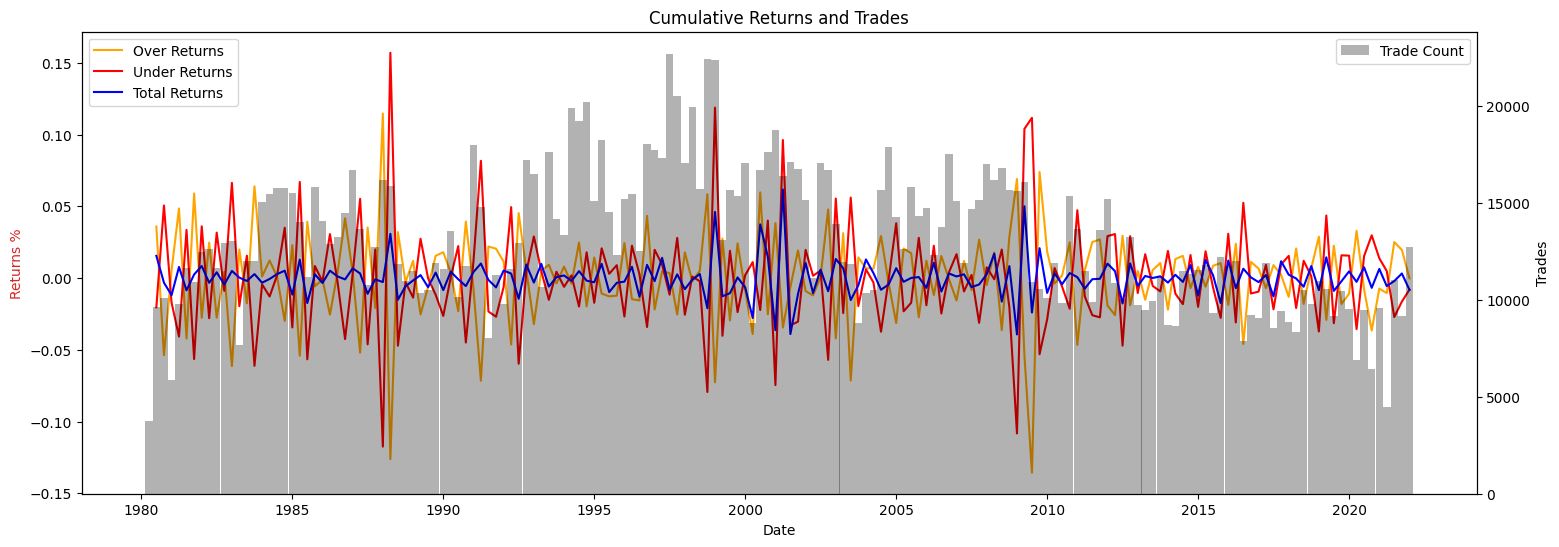

In [19]:
def plot_log_rets(cumulative_returns):
    fig, ax1 = plt.subplots(figsize=(18, 6))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Returns %', color='tab:red')
    ax1.plot(cumulative_returns.index, cumulative_returns['Overs'], label='Over Returns', color='orange')
    ax1.plot(cumulative_returns.index, cumulative_returns['Unders'], label='Under Returns', color='r')
    ax1.plot(cumulative_returns.index, cumulative_returns['Totals'], label='Total Returns', color='b')
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.bar(cumulative_returns.index, cumulative_returns['Trade Count'], label='Trade Count', color='k', alpha=0.3, width=365//4)
    ax2.set_ylabel('Trades', color='k')
    ax2.set_ylabel('Trades', color='k')
    ax2.tick_params(axis='y')
    ax2.legend(loc='upper right')

    return fig, ax1, ax2

plot_log_rets(log_rets)
plt.title('Cumulative Returns and Trades')
plt.show()

In [20]:
from scipy.stats import skew, kurtosis

def get_trade_stats(rets, riskfree=0.035):
    n_periods = rets.index.nunique()

    annualized_return = rets.mean() * n_periods
    annualized_vol = rets.std() * np.sqrt(n_periods)
    sharpe_ratio = (rets.mean() - riskfree) / rets.std() * np.sqrt(n_periods)
    downside_deviation = rets[rets < 0].std() * np.sqrt(n_periods)
    max_drawdown = ((rets.cummax() - rets) / rets.cummax()).max()
    sortino_ratio = (rets.mean() - riskfree) / downside_deviation

    return {
        "Annualized Return": annualized_return,
        "Annualized Vol": annualized_vol,
        "Sharpe Ratio": sharpe_ratio,
        "Downside Deviation": downside_deviation,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Skewness": skew(rets.values),
        "Kurtosis": kurtosis(rets.values)
    }


km_l = get_trade_stats(unders_df[UNDER_RETS])
km_o = get_trade_stats(overs_df[OVER_RETS])
km_t = get_trade_stats(unders_df[UNDER_RETS] + overs_df[OVER_RETS])

km_stats_df = pd.DataFrame({
    'km_long': pd.Series(km_l),
    'km_short': pd.Series(km_o),
    'km_total': pd.Series(km_t)
})

km_stats_df

,km_long,km_short,km_total
Annualized Return,3.929648,-3.373192,0.556456
Annualized Vol,2.362509,2.155867,2.867623
Sharpe Ratio,-5.788486,-9.730744,-5.945184
Downside Deviation,1.539018,1.810411,2.096169
Sortino Ratio,-0.017666,-0.023037,-0.016169
Max Drawdown,2.974704,3.575357,4.162158
Skewness,1.206018,-1.222673,0.145488
Kurtosis,10.572531,11.994422,7.955960


## DBScan

In [21]:
overs_stock_df, unders_stock_df, overs_df, unders_df, re_unders_df, re_overs_df = get_pnl(trade_opportunities_db_df)

print(overs_stock_df.groupby('DATE')[OVER_RETS].mean().tail(5))
print(unders_stock_df.groupby('DATE')[UNDER_RETS].mean().tail(5))

DATE
2021-08-31    0.054903
2021-09-30   -0.018364
2021-10-29    0.029561
2021-11-30   -0.030149
2021-12-31    0.016898
Name: over_rets, dtype: float64
DATE
2021-08-31   -0.029058
2021-09-30    0.019565
2021-10-29   -0.026461
2021-11-30    0.025746
2021-12-31   -0.030709
Name: under_rets, dtype: float64


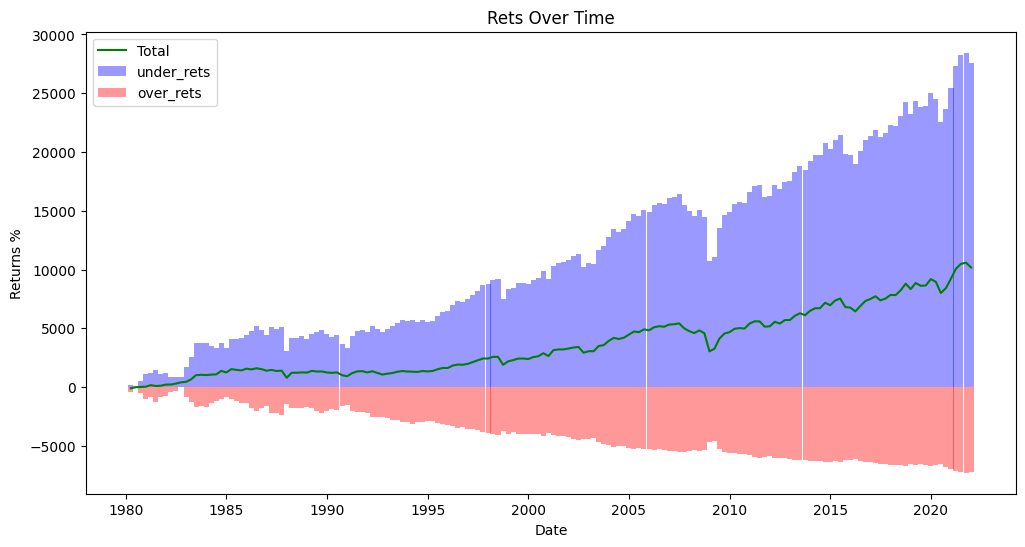

In [22]:
plot_cummulative_rets(re_unders_df, re_overs_df)
plt.show()

In [23]:
log_rets = get_log_rets(re_overs_df, re_unders_df)
log_rets['Totals'].tail(5)

DATE
2020-12-31    0.041415
2021-03-31   -0.020682
2021-06-30    0.013549
2021-09-30    0.001674
2021-12-31   -0.007951
Freq: QE-DEC, Name: Totals, dtype: float64

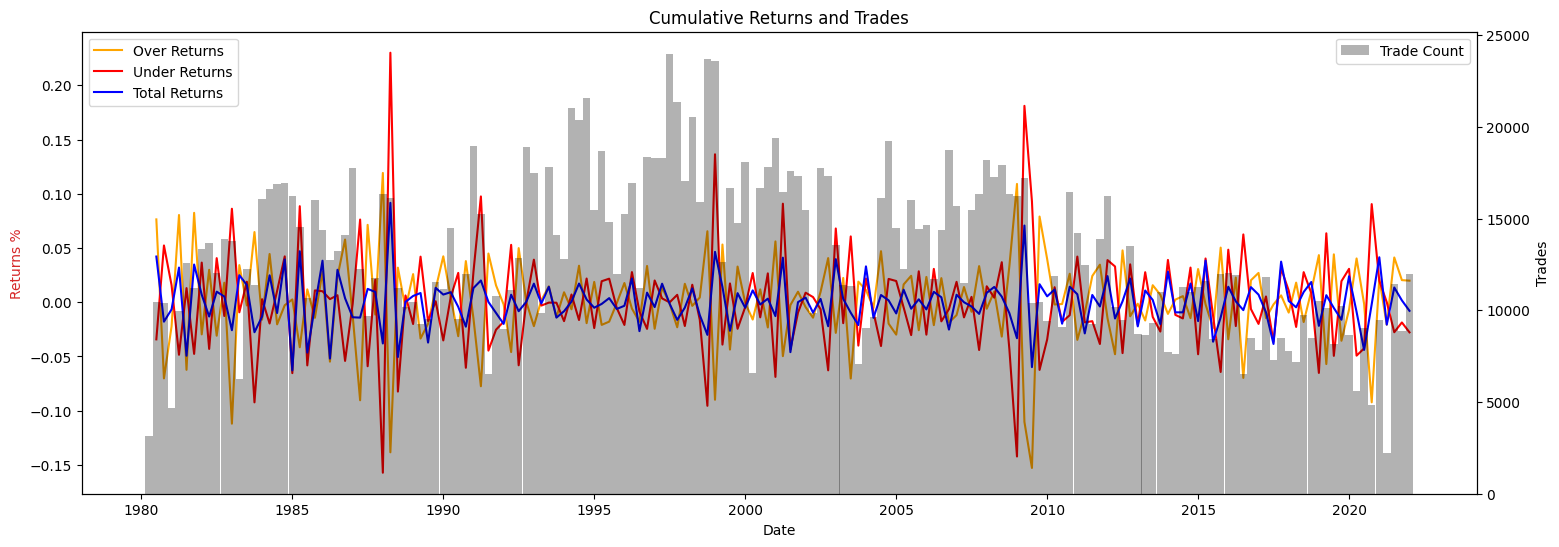

In [24]:
plot_log_rets(log_rets)
plt.title('Cumulative Returns and Trades')
plt.show()

In [25]:
db_l = get_trade_stats(unders_df[UNDER_RETS])
db_o = get_trade_stats(overs_df[OVER_RETS])
db_t = get_trade_stats(unders_df[UNDER_RETS] + overs_df[OVER_RETS])

db_stats_df = pd.DataFrame({
    'db_long': pd.Series(db_l),
    'db_short': pd.Series(db_o),
    'db_total': pd.Series(db_t)
})

db_stats_df

,db_long,db_short,db_total
Annualized Return,3.723734,-3.291194,0.432540
Annualized Vol,1.806831,1.660571,1.997046
Sharpe Ratio,-7.682661,-12.583739,-8.598932
Downside Deviation,1.306812,1.285193,1.462965
Sortino Ratio,-0.021118,-0.032324,-0.023336
Max Drawdown,3.054494,3.005283,3.988606
Skewness,0.295872,-0.645732,0.017648
Kurtosis,6.600904,9.881485,6.607700


## Agglomerative

In [26]:
overs_stock_df, unders_stock_df, overs_df, unders_df, re_unders_df, re_overs_df = get_pnl(trade_opportunities_agg_df)

print(overs_stock_df.groupby('DATE')[OVER_RETS].mean().tail(5))
print(unders_stock_df.groupby('DATE')[UNDER_RETS].mean().tail(5))

DATE
2021-08-31    0.007253
2021-09-30   -0.013004
2021-10-29    0.023849
2021-11-30   -0.029991
2021-12-31    0.013884
Name: over_rets, dtype: float64
DATE
2021-08-31   -0.009505
2021-09-30    0.017643
2021-10-29   -0.018738
2021-11-30    0.035421
2021-12-31   -0.013191
Name: under_rets, dtype: float64


The agglomerative model is the one that diverged the most from the paper, its pairing of stocks was suboptimal, resulting in simulated losses.

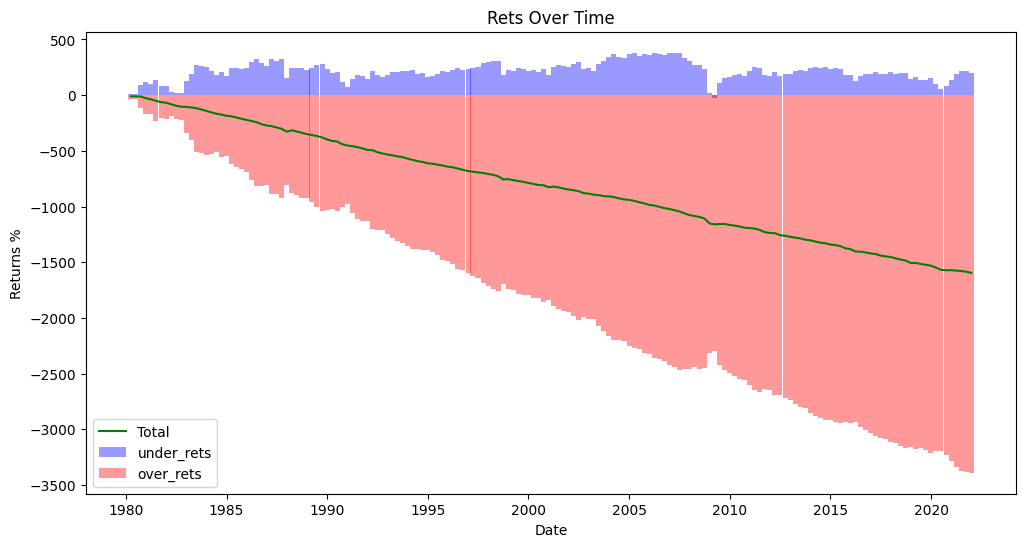

In [27]:
plot_cummulative_rets(re_unders_df, re_overs_df)
plt.show()

In [28]:
log_rets = get_log_rets(re_overs_df, re_unders_df)
log_rets['Totals'].tail(5)

DATE
2020-12-31    0.000283
2021-03-31   -0.001247
2021-06-30    0.000756
2021-09-30    0.001154
2021-12-31   -0.000480
Freq: QE-DEC, Name: Totals, dtype: float64

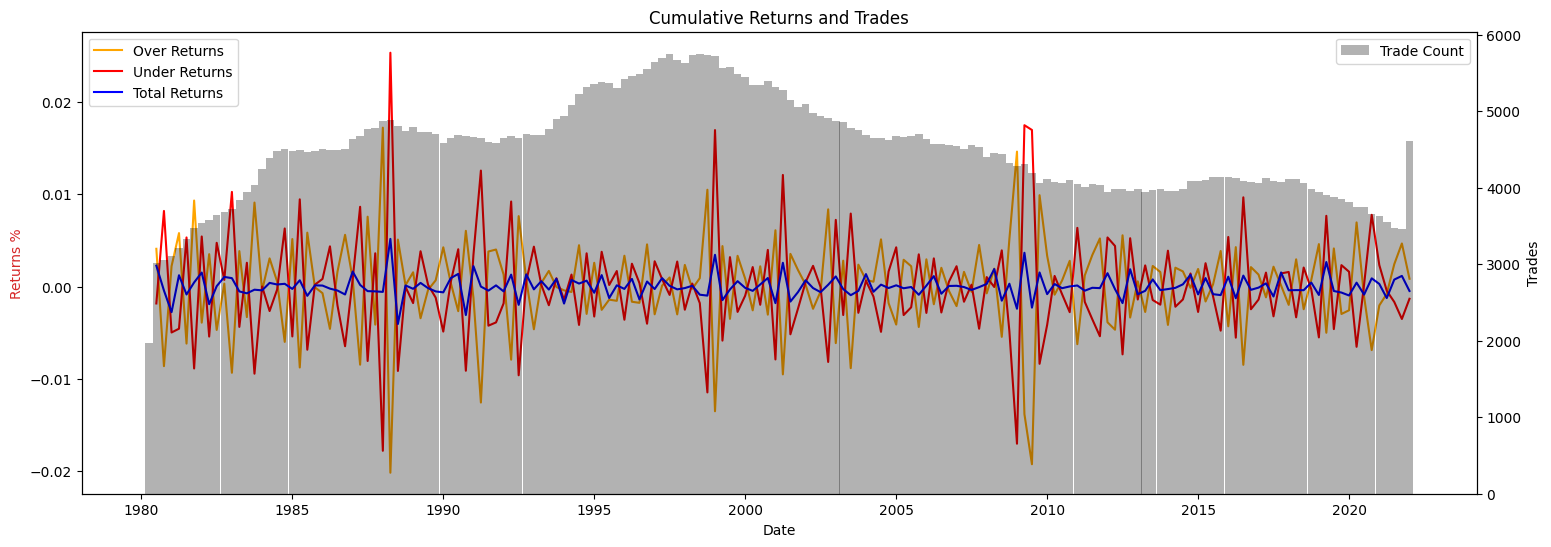

In [29]:
plot_log_rets(log_rets)
plt.title('Cumulative Returns and Trades')
plt.show()

In [30]:
agg_l = get_trade_stats(unders_df[UNDER_RETS])
agg_o = get_trade_stats(overs_df[OVER_RETS])
agg_t = get_trade_stats(unders_df[UNDER_RETS] + overs_df[OVER_RETS])

agg_stats_df = pd.DataFrame({
    'agg_long': pd.Series(agg_l),
    'agg_short': pd.Series(agg_o),
    'agg_total': pd.Series(agg_t)
})

agg_stats_df

,agg_long,agg_short,agg_total
Annualized Return,0.040330,-1.208382,-1.168052
Annualized Vol,0.954010,0.893933,1.152507
Sharpe Ratio,-18.411408,-21.045637,-16.288888
Downside Deviation,0.596690,0.702611,0.802001
Sortino Ratio,-0.058523,-0.053233,-0.046536
Max Drawdown,2.482965,3.497365,3.797554
Skewness,3.043723,-2.701342,0.567310
Kurtosis,84.132567,79.658256,59.281351


## Side-by-side Comparison

In [31]:
all_stats_df = all_stats_df = pd.concat([km_stats_df, db_stats_df, agg_stats_df], axis=1)

all_stats_df

,km_long,km_short,km_total,db_long,db_short,db_total,agg_long,agg_short,agg_total
Annualized Return,3.929648,-3.373192,0.556456,3.723734,-3.291194,0.432540,0.040330,-1.208382,-1.168052
Annualized Vol,2.362509,2.155867,2.867623,1.806831,1.660571,1.997046,0.954010,0.893933,1.152507
Sharpe Ratio,-5.788486,-9.730744,-5.945184,-7.682661,-12.583739,-8.598932,-18.411408,-21.045637,-16.288888
Downside Deviation,1.539018,1.810411,2.096169,1.306812,1.285193,1.462965,0.596690,0.702611,0.802001
Sortino Ratio,-0.017666,-0.023037,-0.016169,-0.021118,-0.032324,-0.023336,-0.058523,-0.053233,-0.046536
Max Drawdown,2.974704,3.575357,4.162158,3.054494,3.005283,3.988606,2.482965,3.497365,3.797554
Skewness,1.206018,-1.222673,0.145488,0.295872,-0.645732,0.017648,3.043723,-2.701342,0.567310
Kurtosis,10.572531,11.994422,7.955960,6.600904,9.881485,6.607700,84.132567,79.658256,59.281351


Unfortunately we didn't replicate the results of the paper. Though we didn't utilize their data, nor had the full hyper-params they would have used for their clustering models.

# Conclusion

In this article, we explored three clustering methods: k -means, DBSCAN, and agglomerative clustering. Using CRSP data from Gu et al. (2020) we attempted to replicate and improve on the findings of Han et al. (2023) in their unsupervised learning for pairs trading.

In thier paper, the found that the agglomerative clustering-based strategy is optimal, with an 
cess annualised return of 23.8%, an annualised Sharpe ratio of 2.69. and a maximum drawdown of 12.3%.

## References

- [Han, Chulwoo, Zhaodong He, and Alenson Jun Wei Toh. "Pairs trading via unsupervised learning." European Journal of Operational Research 307.2 (2023): 929-947.](https://www.sciencedirect.com/science/article/pii/S037722172200769X)
- [Gu, Shihao, Bryan Kelly, and Dacheng Xiu. "Empirical asset pricing via machine learning." The Review of Financial Studies 33.5 (2020): 2223-2273.](https://academic.oup.com/rfs/article/33/5/2223/5758276)
- [Gu, Shihao, Bryan Kelly, and Dacheng Xiu. "Autoencoder asset pricing models." Journal of Econometrics 222.1 (2021): 429-450.](https://www.sciencedirect.com/science/article/pii/S0304407620301998)
- [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
- [sklearn.cluster.DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
- [sklearn.cluster.AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)
- [Pyarrow](https://arrow.apache.org/docs/python/index.html)
- [Momentum and Reversion Trading Signals Analysis](https://medium.com/call-for-atlas/momentum-and-reversion-the-poor-mans-trading-strategies-9b8e1e6d3496).

## Github

Article here is also available on [Github](https://github.com/adamd1985/pairs_trading_unsupervised_learning)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/unsupervised-learning-as-signals-for-pairs-trading)

## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.